In [1]:
import tensorflow as tf
print(tf.__version__)

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
import time
import datetime
import os
from scipy.spatial import distance

from IPython import display

2.3.0


In [2]:
print(distance.jensenshannon([1, 0,3], [0, 1,2]))
print(distance.jensenshannon([0, 1,2], [1, 0,3]))

0.45099237862867836
0.45099237862867836


# Model

## Generator

In [3]:
INPUT_SIZE = 10
OUTPUT_SIZE = 3

def generator_model():
    #Creates a new generator with new weights and no pior training
    #Current model is a simple fully connected with 3-layers depth
    input_shape=(INPUT_SIZE,)
    input1 =  layers.Input(input_shape)

    x = layers.Dense(64, activation = "tanh")(input1)
    
    x = layers.Dense(64, activation = "tanh")(x)
    
    x = layers.Dense(64, activation = "tanh")(x)
    
    x = layers.Dense(OUTPUT_SIZE)(x)
    
    model = tf.keras.Model(input1,x)
    return model

In [4]:
generator = generator_model()
generator.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 9,219
Trainable params: 9,219
Non-trainable params: 0
_________________________________________________________________


## Discriminator

In [5]:
def discriminator_model():
    #Creates a new discriminator with new weights and no pior training
    #Current model is a simple fully connected with 3-layers depth
    input_shape = (OUTPUT_SIZE,)
    data = layers.Input(input_shape)
    
    x = layers.Dense(64, activation = "tanh")(data)
    
    x = layers.Dense(64, activation = "tanh")(x)

    x = layers.Dense(64, activation = "tanh")(x)
    
    x = layers.Dense(1,activation = "sigmoid")(x)
    
    model = tf.keras.Model(data,x)
    return model

In [6]:
discriminator = discriminator_model()
discriminator.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 8,641
Trainable params: 8,641
Non-trainable params: 0
_________________________________________________________________


# Optimizers & Losses

In [7]:
#Adjusted non-saturating gan losses
def generator_loss(fake_output, offset = 0.01):
    return -tf.reduce_mean(tf.math.log(fake_output+offset))

def discriminator_loss(real_output, fake_output, offset=0.01):
    return -tf.reduce_mean(tf.math.log(1-fake_output+offset)) -tf.reduce_mean(tf.math.log(real_output+offset))

In [8]:
#Optmizers for SGD
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training Loop

In [9]:
BATCH_SIZE = 1024

def generate_input_noise(size):
    #use this function to feed the generator
    return tf.random.uniform([size,INPUT_SIZE],minval = 0,maxval = 1)
    #return tf.random.normal([size,INPUT_SIZE])

def generate_target_function(size, sigma = 1):
    #target distribution to be aproximated
    return np.random.lognormal(0,sigma,size = size)

def generate_and_save_histograms(epoch,test_input):
    #Create and save figures to visualize progress
    #use seed to generate predictions
    predictions = generator(test_input, training = False)
    #revert normalization
    predictions = np.array(predictions)*STD+MEAN
    
    #Create figure
    fig_size = (16,4)
    fig, ax = plt.subplots(figsize=fig_size, nrows=1, ncols=OUTPUT_SIZE)
    fig.patch.set_facecolor('white')
    ax = ax.flatten()
    
    #Plot generated and true distribution histograms together
    hist=[]
    for i in range(OUTPUT_SIZE):
        x = ax[i].hist([predictions[:,i],generate_target_function(BATCH_SIZE,sigma[i])], bins = 32,
                   histtype = "step", density = True, linewidth=4, label=["Prediction","Target"], color=["blue","red"])
        plt.legend()
        hist.append(x[0])
        
    #Show and save figure
    plt.savefig(images_log_dir+'\epoch_{:04d}.png'.format(epoch))
    plt.show()
    
    return hist

In [10]:
def train_step(data,labels):
    #Traingning step for a single batch
    noise = generate_input_noise(BATCH_SIZE)

    print("Creating graph with:",data.shape)
    with tf.GradientTape(persistent=True) as tape:
        print("Generating data")
        generated_data = generator(noise, training=True)

        print("Calculating discriminator results")
        real_output = discriminator(data, training = True)
        fake_output = discriminator(generated_data, training = True)
        
        print("Calculating loss")
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    print("Calculating gradient")
    gradients_of_generator = tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = tape.gradient(disc_loss, discriminator.trainable_variables)
    
    print("Applying gradient")
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    print("Train step finished!")
    return gen_loss, disc_loss

In [11]:
def train(Epochs, save = True, hist_interval = 20):
    print("Starting training")
    gen_loss=[]
    disc_loss=[]
    
    tf_train_step = tf.function()(train_step)
    for epoch in range(1,Epochs+1):
        start = time.time()

        print("Epoch {}".format(epoch))
        
        g_loss = 0
        d_loss = 0
        for data_batch,labels in dataset:
            g,d = tf_train_step(data_batch,labels)
            
            g_loss = g + g_loss
            d_loss = d + d_loss
        
        gen_loss.append(g_loss)
        disc_loss.append(d_loss)
        
        if save:
            with metrics_summary_writer.as_default():
                tf.summary.scalar('gen_loss', g_loss, step=epoch)
                tf.summary.scalar('disc_loss', d_loss, step=epoch)

            if(epoch%hist_interval==0):
                display.clear_output()

                plt.plot(gen_loss,label="Generator")
                plt.plot(disc_loss,label="Discriminator")
                plt.legend()
                plt.show()

            if(epoch%hist_interval==0):
                hist = generate_and_save_histograms(epoch,seed)

                js_distance = 0
                for i,s in enumerate(sigma):
                    js_distance += distance.jensenshannon(hist[i][0],hist[i][1])

                js_distance_mean = js_distance/3

                with metrics_summary_writer.as_default():
                    tf.summary.scalar('distance_mean', js_distance_mean, step=epoch)
        
        print ("Time for epoch {}/{} is {} sec".format(epoch,Epochs, time.time()-start))


# Creating Dataset

Creating Dataset
Dataset histogram


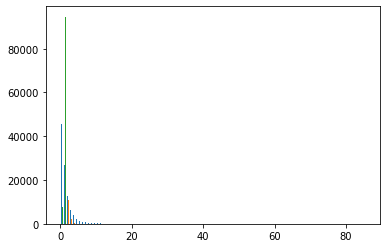

Dataset plot


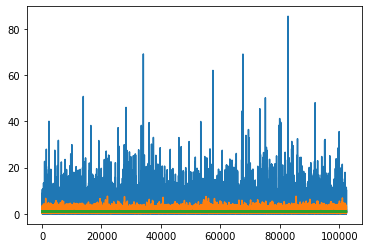

In [12]:
#Dataset parameters
set_size = 100*BATCH_SIZE
dataset_size = OUTPUT_SIZE*set_size
sigma = [1,0.5,0.1]

print("Creating Dataset")
train_data = np.zeros([OUTPUT_SIZE,set_size]).astype("float32")
labels = np.ones([OUTPUT_SIZE,set_size]).astype("float32")
for i in range(OUTPUT_SIZE):
    labels[i] = labels[i]*sigma[i]
    train_data[i] = generate_target_function(set_size,sigma[i])

labels = labels.transpose()
train_data = train_data.transpose()

print("Dataset histogram")
plt.hist(train_data,bins = 100)
plt.show() 

print("Dataset plot")
plt.plot(train_data)
plt.show()

#Normalization
MEAN = np.mean(train_data)
STD = np.std(train_data)  
train_data = (train_data - MEAN)/STD

#Discriminator/Generator test
discriminator(generator(generate_input_noise(BATCH_SIZE)))

dataset = tf.data.Dataset.from_tensor_slices((train_data, labels))
dataset = dataset.shuffle(2*BATCH_SIZE).batch(BATCH_SIZE)



# Training and testing

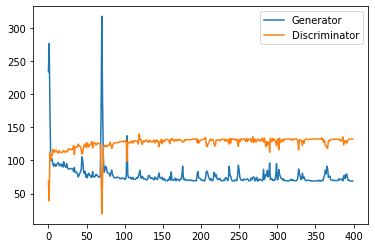

No handles with labels found to put in legend.
No handles with labels found to put in legend.


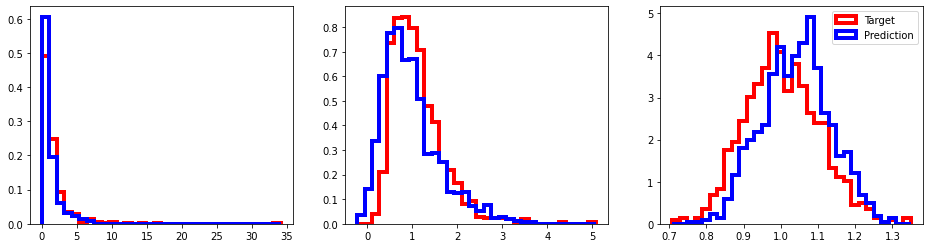

Time for epoch 400/400 is 0.8714711666107178 sec


In [13]:
for _ in range(10):
    seed = generate_input_noise(BATCH_SIZE)

    generator = generator_model()
    discriminator = discriminator_model()

    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    metrics_log_dir = 'logs/metrics/'+ current_time
    metrics_summary_writer = tf.summary.create_file_writer(metrics_log_dir)

    gen_loss = tf.keras.metrics.Mean('gen_loss', dtype=tf.float32)
    disc_loss = tf.keras.metrics.Mean('disc_loss', dtype=tf.float32)
    
    images_log_dir = 'logs/images/'+ current_time 
    os.makedirs(images_log_dir)

    tf.keras.utils.plot_model(generator,to_file=images_log_dir+"\gen_gan.png",show_shapes=False)
    tf.keras.utils.plot_model(discriminator,to_file=images_log_dir+"\disc_gan.png",show_shapes=False)

    train(400)

In [14]:
%load_ext tensorboard


In [15]:
%tensorboard --logdir logs/metrics/
